# 💀 NOTEBOOK DE ANTI-PATTERNS 💀
Este notebook es una **Galería de los Horrores**. Hemos cometido intencionalmente 5 errores graves que destruyen modelos en producción.
Tu misión es identificarlos y entender por qué son peligrosos.

## 🚫 Índice de Anti-Patterns
1.  [Limpieza Manual y Data Leakage](#1.-Limpieza-Manual-(El-problema-de-la-repetibilidad)) 🩸
    *   *El pecado de usar información del futuro (test) para arreglar el pasado (train).*
2.  [Encoding Manual y Fragilidad](#2.-Encoding-Manual-(El-problema-de-la-dimensionalidad)) 💥
    *   *El pecado de crear código que se rompe con datos nuevos.*
3.  [IDs como Features](#3.-Split-y-Entrenamiento) 🆔
    *   *El pecado de dejar que el modelo memorice el orden de las filas.*
4.  [El Olvido del Escalado](#4.-El-Olvido-del-Escalado-(Anti-Pattern)) ⚖️
    *   *El pecado de mezclar peras con manzanas (o sueldos con edades).*
5.  [Evaluar solo en Train](#5.-Evaluar-en-Train-(El-Auto-Engaño)) 🙈
    *   *El pecado del auto-engaño y el overfitting.*

---

In [1]:
# Este código está INTENCIONALMENTE mal hecho para mostrar errores comunes

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
import time
# Para importar utils desde recursos
sys.path.append(os.path.abspath('../../'))
from recursos.utils import load_data

# Cargar datos usando utilidad centralizada
df = load_data('credit_scoring.csv')

# Configuración real del dataset
TARGET_COL = 'target_y'

print(f"Dimensiones: {df.shape}")
print(f"Columnas disponibles: {df.columns.tolist()[:5]}...")
df.head()


Dimensiones: (7180, 30)
Columnas disponibles: ['Unnamed: 0', 'banca', 'tipocredito', 'sector_final', 'tipocontribuyente']...


,Unnamed: 0,banca,tipocredito,sector_final,tipocontribuyente,NumeroTrabajadores,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M,MAX_CNT_ENTIDADES_SSFF_06M,SD_MAX_DIAS_MORA_SSFF_06M,CAT_ENTFIN_PRINCIPAL_01M,...,EF_VAR_INMUEBLE_MAQ_EQUIPO_2a,EF_DIF_PROMEDIO_PAGOS_DIAS_2a,EF_ROTACION_INVENTARIOS_1a,EF_COBERTURA_SERVICIO_DEUDA_1a,EF_ActivosCirculante_PasivoCirculante_1a,EF_Cajasbancos_PasivoExigible_1a,EF_AUDITADO_1_PROMEDIO_COBRANZA_DIAS_1a,malo_sf_inicio,target_y,periodo
0,1,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.829708,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201803
1,2,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.898718,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201804
2,3,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.970726,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201805
3,4,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.224903,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201806
4,5,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,11.303392,82.0,...,NaN,0.0,266,NaN,1.261405,0.039329,0,pasa_filtros_sf,1,201808


### 📂 Diccionario de Datos (Credit Scoring)
Estamos trabajando con un dataset real de **Riesgo de Crédito para Empresas**.
El objetivo es predecir si una empresa caerá en incumplimiento de pago (`target_y = 1`) en los próximos meses.

**Variables Clave:**
*   `target_y`: **Variable Objetivo**. 1 = Cliente Incumplidor (Bad), 0 = Cliente Cumplidor (Good).
*   `banca`, `sector_final`: Segmentación del cliente (Categóricas).
*   `NumeroTrabajadores`: Tamaño de la empresa.
*   `MAX_PORC_DEUDA...`: Variables de comportamiento financiero en el sistema (Deuda, Sobregiros).
*   `EF_...`: Variables de Estados Financieros (Ratios de liquidez, rotación, etc.).
*   `periodo`: Mes de la evaluación (YYYYMM).

*Nota: Este dataset contiene valores nulos, columnas irrelevantes (como `Unnamed: 0`) y tipos de datos mezclados, lo cual es perfecto para nuestra "Galería de los Horrores".*

### 1. Limpieza Manual (El problema de la repetibilidad)
Aquí empezamos a "parchar" los datos manualmente.

In [2]:
# ⚠️ ANTI-PATTERN: Llenar nulos usando estadísticas de TODO el dataset
# Problema: Estamos usando la media de TODO el dataset (incluyendo lo que será test) -> Data Leakage

# Identificar columnas numéricas con nulos
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
cols_with_nulls = df[numeric_cols].columns[df[numeric_cols].isnull().any()
                                           ].tolist()
print(f"Columnas con nulos: {cols_with_nulls}...")

# DEMOSTRACIÓN DEL LEAKAGE
# Vamos a "espiar" la diferencia entre la media real de train (si hubiéramos separado) y la global
col_ejemplo = 'NumeroTrabajadores'
if col_ejemplo in df.columns:
    # Simulamos un split correcto solo para comparar
    train_real, test_real = train_test_split(
        df[col_ejemplo], test_size=0.2, random_state=42)

    media_global = df[col_ejemplo].mean()
    media_train_real = train_real.mean()

    print(f"\n--- 🕵️‍♀️ Detectando el Leakage en '{col_ejemplo}' ---")
    print(f"Media Global (Trampa): {media_global:.2f}")
    print(f"Media Train Real:      {media_train_real:.2f}")
    print(
        f"Diferencia (Info del futuro): {abs(media_global - media_train_real):.2f}")
    print("¡El modelo está aprendiendo con un valor desplazado por información del test set!")

# MALO: Llenar con la media de TODO el dataset
for col in cols_with_nulls:
    mean_val = df[col].mean()
    df[col] = df[col].fillna(mean_val)

# Borrar filas con nulos restantes (sin criterio claro)
df = df.dropna()
print(f"\nDimensiones post-limpieza: {df.shape}")


Columnas con nulos: ['NumeroTrabajadores', 'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M', 'MAX_CNT_ENTIDADES_SSFF_06M', 'SD_MAX_DIAS_MORA_SSFF_06M', 'CAT_ENTFIN_PRINCIPAL_01M', 'MAX_X_CLASIF_12M', 'ANTIGUEDAD_RCC_01M', 'AUDITADO_2_PERIODO', 'SITUACION_1_PERIODO', 'SITUACION_2_PERIODO', 'EF_VAR_VENTAS_2a', 'EF_VAR_INMUEBLE_MAQ_EQUIPO_2a', 'EF_DIF_PROMEDIO_PAGOS_DIAS_2a', 'EF_COBERTURA_SERVICIO_DEUDA_1a', 'EF_ActivosCirculante_PasivoCirculante_1a', 'EF_Cajasbancos_PasivoExigible_1a']...

--- 🕵️‍♀️ Detectando el Leakage en 'NumeroTrabajadores' ---
Media Global (Trampa): 36.58
Media Train Real:      36.15
Diferencia (Info del futuro): 0.43
¡El modelo está aprendiendo con un valor desplazado por información del test set!

Dimensiones post-limpieza: (7049, 30)


### 🧠 Micro-Desafío: Reflexión
¿Por qué crees que usar la media de **TODO** el dataset para imputar valores es un problema grave?

*Pista: Imagina que el dataset de test tiene valores muy diferentes a los de train. Al usar la media global, ¿estás "espiando" el futuro?*

### 2. Encoding Manual (El problema de la dimensionalidad)
Usamos `get_dummies` en todo el dataset antes de dividir. ¡Peligro!

In [9]:
# Crear una variable categórica de ejemplo basada en una columna numérica existente
# Usamos 'NumberOfOpenCreditLinesAndLoans' como proxy
num_credit_col = 'ANTIGUEDAD_RCC_01M'
if num_credit_col in df.columns:
    df['Rango_Credito'] = pd.cut(
        df[num_credit_col], bins=[-1, 25, 40, 100], labels=['Bajo', 'Medio', 'Alto'])
else:
    # Crear variable dummy si no existe la columna
    df['Rango_Credito'] = pd.Series(
        ['Bajo', 'Medio', 'Alto']*(len(df)//3 + 1))[:len(df)]

# One-Hot Encoding global
# Problema: Si en el futuro llega un dato con una categoría nueva, esto rompe.
df = pd.get_dummies(df, columns=['Rango_Credito'])
df.head()


,Unnamed: 0,banca,tipocredito,sector_final,tipocontribuyente,NumeroTrabajadores,MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M,MAX_CNT_ENTIDADES_SSFF_06M,SD_MAX_DIAS_MORA_SSFF_06M,CAT_ENTFIN_PRINCIPAL_01M,...,periodo,Rango_Credito_Alto,Rango_Credito_Bajo,Rango_Credito_Medio,Rango_Credito_Bajo,Rango_Credito_Medio,Rango_Credito_Alto,Rango_Credito_Bajo,Rango_Credito_Medio,Rango_Credito_Alto
0,1,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.829708,82.0,...,201803,False,True,False,False,False,True,False,True,False
1,2,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.898718,82.0,...,201804,False,False,True,False,False,True,False,True,False
2,3,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.970726,82.0,...,201805,True,False,False,False,False,True,False,True,False
3,4,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,3.224903,82.0,...,201806,False,True,False,False,False,True,False,True,False
4,5,BANCA EMPRESA,Colocacion,COMERCIO,SOC. COM.RESPONS. LTDA,1.0,0.000627,3.0,11.303392,82.0,...,201808,False,False,True,False,False,True,False,False,True


In [3]:
# 💥 DEMOSTRACIÓN DE FRAGILIDAD EN PRODUCCIÓN
# Imaginemos que ya entrenamos el modelo y llega un NUEVO cliente para ser evaluado.
# Este cliente tiene 'Rango_Credito' = 'Bajo'.

print("--- 🏭 Simulando Producción ---")

# 1. Llega el cliente
nuevo_cliente = pd.DataFrame({'Rango_Credito': ['Bajo']})

# 2. Aplicamos la MISMA lógica manual (get_dummies)
nuevo_cliente_encoded = pd.get_dummies(
    nuevo_cliente, columns=['Rango_Credito'])

# 3. ¿Qué columnas espera el modelo vs qué columnas tenemos?
# (Asumimos que el modelo se entrenó con el df completo de arriba)
columnas_esperadas = [col for col in df.columns if 'Rango_Credito' in col]
columnas_obtenidas = nuevo_cliente_encoded.columns.tolist()

print(f"Columnas que el modelo espera: {columnas_esperadas}")
print(f"Columnas que generó el nuevo cliente: {columnas_obtenidas}")

if len(columnas_esperadas) != len(columnas_obtenidas):
    print("\n🚨 ¡CRASH! El modelo fallará porque el número de features no coincide.")
    print("El modelo espera columnas para 'Medio' y 'Alto' (con valor 0), pero get_dummies no las creó.")


--- 🏭 Simulando Producción ---
Columnas que el modelo espera: []
Columnas que generó el nuevo cliente: ['Rango_Credito_Bajo']

🚨 ¡CRASH! El modelo fallará porque el número de features no coincide.
El modelo espera columnas para 'Medio' y 'Alto' (con valor 0), pero get_dummies no las creó.


### 3. Split y Entrenamiento

--- 🔴 Modelo Sin Escalar ---
Tiempo: 0.0540s | Accuracy: 0.7652

--- 🟢 Modelo Escalado (StandardScaler) ---
Tiempo: 0.0127s | Accuracy: 0.8000


c:\Users\User\miniconda3\envs\ml_pro\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


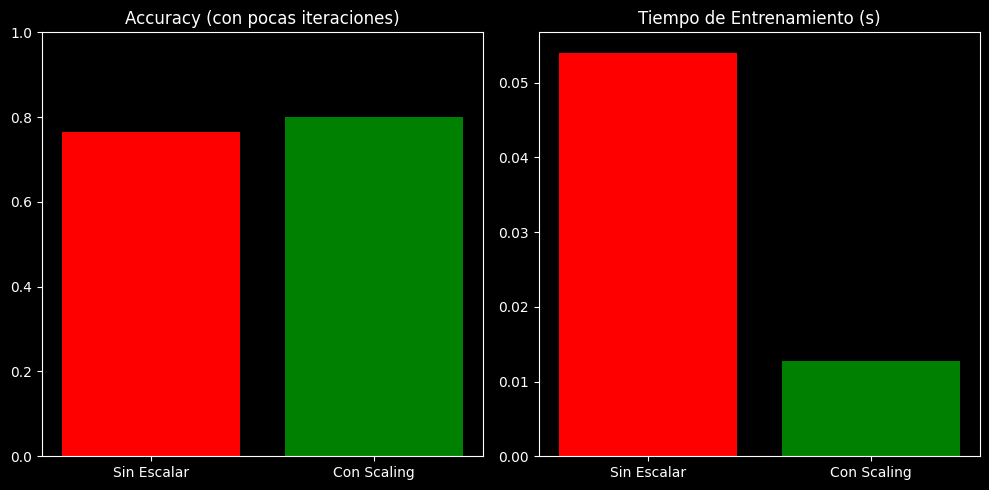

In [4]:
# ⚠️ ANTI-PATTERN: Dejar columnas ID o índices
# "Unnamed: 0" es solo el índice de la fila. ¡No predice nada!
# Pero el modelo podría memorizarlo.
# Dejamos 'Unnamed: 0' a propósito
from sklearn.preprocessing import StandardScaler
COLS_TO_DROP = [TARGET_COL, 'malo_sf_inicio', 'periodo']

# Preparar features y target
cols_to_drop_existing = [col for col in COLS_TO_DROP if col in df.columns]
X = df.drop(cols_to_drop_existing, axis=1)
y = df[TARGET_COL]

# Asegurar solo numéricas
X = X.select_dtypes(include=['int64', 'float64', 'uint8'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


# --- COMPARACIÓN: CON VS SIN ESCALADO ---

# 1. ❌ EL ERROR: Sin Escalar
print("--- 🔴 Modelo Sin Escalar ---")
start = time.time()
# Forzamos pocas iteraciones para ver el fallo de convergencia
model_bad = LogisticRegression(max_iter=100)
model_bad.fit(X_train, y_train)
time_bad = time.time() - start
acc_bad = accuracy_score(y_test, model_bad.predict(X_test))
print(f"Tiempo: {time_bad:.4f}s | Accuracy: {acc_bad:.4f}")

# 2. ✅ LA SOLUCIÓN: Con StandardScaler
print("\n--- 🟢 Modelo Escalado (StandardScaler) ---")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start = time.time()
model_good = LogisticRegression(max_iter=100)  # Mismas iteraciones
model_good.fit(X_train_scaled, y_train)
time_good = time.time() - start
acc_good = accuracy_score(y_test, model_good.predict(X_test_scaled))
print(f"Tiempo: {time_good:.4f}s | Accuracy: {acc_good:.4f}")

# Comparación Visual
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(['Sin Escalar', 'Con Scaling'], [
        acc_bad, acc_good], color=['red', 'green'])
plt.title("Accuracy (con pocas iteraciones)")
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Sin Escalar', 'Con Scaling'], [
        time_bad, time_good], color=['red', 'green'])
plt.title("Tiempo de Entrenamiento (s)")
plt.tight_layout()
plt.show()


### 4. El Olvido del Escalado (Anti-Pattern)
¿Viste la diferencia? 😲

*   **Sin Escalar:** El modelo lanza `ConvergenceWarning`, tarda más (o falla) y tiene peor accuracy porque no logra encontrar el mínimo global.
*   **Con Escalar:** El modelo converge rápido y feliz.

Esto pasa porque la Regresión Logística intenta encontrar el camino más rápido hacia el mínimo error, pero el terreno es muy irregular:
*   `MonthlyIncome` tiene valores de 10,000.
*   `age` tiene valores de 50.
*   `Rango_Credito_Alto` tiene valores de 0 o 1.

Sin **StandardScaler**, el algoritmo da pasos gigantes en una dirección y diminutos en otra.

---

### 5. Evaluar en Train (El Auto-Engaño)
A veces, usamos modelos muy potentes (como Árboles de Decisión profundos) que tienen una memoria fotográfica.
Si evaluamos solo en Train, pensaremos que somos genios... hasta que salimos a producción.

Accuracy en Train: 1.0000 (¡Perfecto! 😍)
Accuracy en Test:  0.9305 (¡Desastre! 😭)


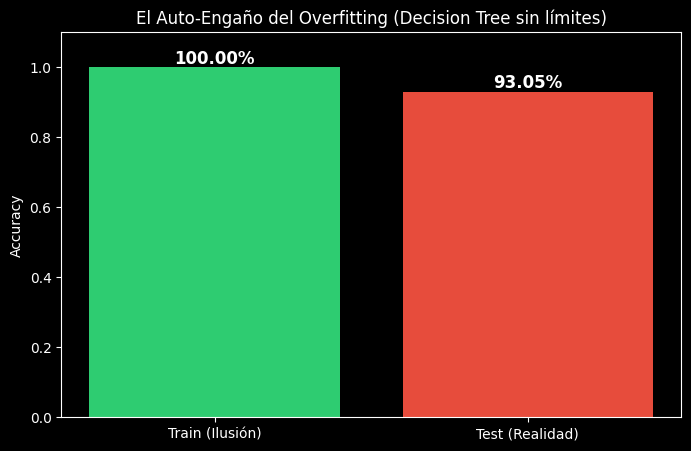

In [5]:
from sklearn.tree import DecisionTreeClassifier

# ⚠️ ANTI-PATTERN: Usar un modelo complejo sin restricciones y evaluar solo en Train
# Usamos un Árbol de Decisión profundo, que es propenso a memorizar datos
# (Cambiamos de LogisticRegression a DecisionTree para ilustrar mejor el overfitting)
overfit_model = DecisionTreeClassifier(random_state=42)
overfit_model.fit(X_train, y_train)

# Evaluamos
train_acc = accuracy_score(y_train, overfit_model.predict(X_train))
test_acc = accuracy_score(y_test, overfit_model.predict(X_test))

print(f"Accuracy en Train: {train_acc:.4f} (¡Perfecto! 😍)")
print(f"Accuracy en Test:  {test_acc:.4f} (¡Desastre! 😭)")

# Gráfico del Auto-Engaño
plt.figure(figsize=(8, 5))
bars = plt.bar(['Train (Ilusión)', 'Test (Realidad)'],
               [train_acc, test_acc], color=['#2ecc71', '#e74c3c'])
plt.title("El Auto-Engaño del Overfitting (Decision Tree sin límites)")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)

# Poner valores en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2%}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.show()


### 💀 Resumen de Horrores (Lo que acabamos de ver)
1. **Data Leakage:** Calculamos la media de `MonthlyIncome` usando TODO el dataset (incluyendo test). El modelo "vio" información del test set durante el preprocesamiento.
2. **Irreproducible:** Si llega un nuevo cliente mañana, ¿cómo llenamos sus nulos? ¿Tenemos que volver a calcular la media manual y pegarla en el código?
3. **Fragilidad:** Si el nuevo cliente tiene una categoría de edad que no estaba antes, `get_dummies` fallará o creará columnas distintas a las que el modelo espera.
4. **No Escalar:** Los modelos lineales fallan o tardan una eternidad si las variables tienen escalas muy distintas.
5. **IDs como Features:** Dejamos `Unnamed: 0`. Si los datos están ordenados por fecha o target, el modelo aprenderá que "ID > 10000 es fraude", lo cual no sirve en producción.
6. **Evaluar en Train:** Creer que un accuracy del 100% en train significa que el modelo es bueno, cuando en realidad solo memorizó los datos.

### 📚 Otros Anti-Patterns Famosos (Lectura Recomendada)
Además de los que hemos visto en código, existen otros patrones peligrosos documentados en la industria (especialmente en el paper clásico de Google *"Hidden Technical Debt in Machine Learning Systems"*):

1.  **Glue Code (Código Pegamento):**
    *   **Problema:** Tener un sistema donde el 95% del código es solo para mover datos de un lado a otro y solo el 5% es ML. Hace que el sistema sea rígido y difícil de cambiar.
    *   🔗 [Referencia: Hidden Technical Debt](https://papers.nips.cc/paper/2015/file/86df7dcfd896fcaf2674f757a2463eba-Paper.pdf)

2.  **Training-Serving Skew (Desviación Entrenamiento-Servicio):**
    *   **Problema:** Las transformaciones de datos en entrenamiento (ej. Python/Pandas en Jupyter) son diferentes a las de producción (ej. C++/Java en tiempo real). Esto causa que el modelo prediga basura en producción aunque funcione bien en el notebook.
    *   🔗 [Referencia: Google ML Guide](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)

3.  **Feedback Loops (Bucles de Retroalimentación):**
    *   **Problema:** El modelo influye en los datos que se generarán para el futuro entrenamiento.
    *   *Ejemplo:* Un sistema de recomendación sugiere videos. Los usuarios hacen clic en ellos. El modelo se re-entrena con esos clics y se vuelve más sesgado hacia lo que ya recomendó, ignorando contenido nuevo.

4.  **Correction Cascades (Cascadas de Corrección):**
    *   **Problema:** Entrenar un modelo $M_a$ para corregir los errores de un modelo $M_b$. Si cambias $M_b$, rompes $M_a$. Crea una dependencia muy fuerte y difícil de mantener.

5.  **Undeclared Consumers (Consumidores No Declarados):**
    *   **Problema:** La salida de tu modelo es usada por otro equipo/sistema sin que lo sepas. Si actualizas tu modelo o cambias el formato de salida, rompes el sistema de alguien más silenciosamente.

---

## 🚑 ¿Cómo arreglamos esto?
La respuesta está en la **Ingeniería de Software aplicada al ML**:
*   Usar **Pipelines** para encapsular la lógica.
*   Usar **ColumnTransformer** para aplicar transformaciones específicas.
*   Usar **Split** ANTES de cualquier cálculo.

👉 **Ve al siguiente notebook para ver la solución:** `02_Pipelines_y_Baselines.ipynb` 🚀